In [1]:
import numpy as np
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
np.load = np_load_old

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /=std

In [7]:
from tensorflow.python.keras import models, layers

In [21]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [30]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_hisstory = []
for i in range(k):
    print('processing fold#', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i + num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i + num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0
    )
    
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0)
    print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_hisstory.append(mae_history)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)

processing fold# 0
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold# 1
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold# 2
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold# 3
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [31]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_hisstory]) for i in range(num_epochs)
]

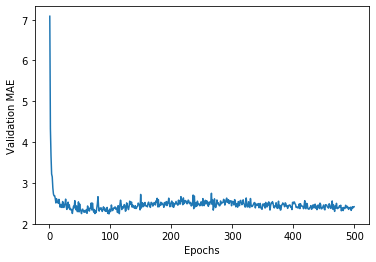

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [33]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [34]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

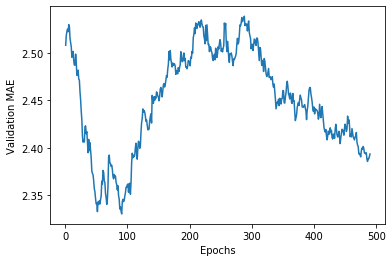

In [35]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()